# Code summary
This notebook will guide a very simple example of how to train a classifier (aka "jet-tagger") with pytorch using th ATLAS top-tagging dataset at https://opendata.cern.ch/record/80030.

To be able to run this tutorial within a reasonable time, we will develop just a tagger on the 16 high-level features stored. Constituent level taggers can be easily done using the below recipes, but the training time can easily go into the range of days. For similar time reasons, we will only run on one file of 1 million jets, as opposed to the full dataset (which is several hundred GB in total size to download locally as well).

We will assume you are familiar with the inspect_inputs.ipynb notebook already and will skip the explanantion on the file format and how to access the data.

Much of the code below is more elaborate then is needed for a simple tutorial, but this is so that it can provide a useful copy-and-paste template for your own projects.

## Acessing the data
Exactly as before, lets download an input file to inspect

In [1]:
import sys,os
if not(os.path.isfile("train_nominal_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz --output train_nominal_000.h5.gz
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz --output test_nominal_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz
    !gunzip -f train_nominal_000.h5.gz
    !gunzip -f test_nominal_000.h5.gz

And let's import some packages we will need

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchinfo import summary

import matplotlib.pyplot as plt
import h5py
import numpy as np
import time

## Preparing the inputs for training

90% of the hard work of running any machine-learning algorithm is setting up your data in the right form.

To faciliate reading the data very efficiently we will use the pytorch `DataLoader` class to do most of this heavy lifting. This is one of the only things you would need to adapt if you want to use this code for other NN training. For each dataset you need to define a new class which inherits from pytorch `Dataset` which specifies how to access your data. It needs a `__init__` method to do any preamble works, a  `__getitem__` method which specifies how to access a single data sample, and `__len__` method to specify how to figure out the batch size correctly.

After this the pytorch dataloader will handle the rest!

For this case we will use the `__init__` function to opent the necessary file, and read the HDF5 "Dataset" objects. We also will be mentally pro-active and feed the code an optional transform object to pre-process the data. The `__getitem__` just then simply calls the specific entry of the HDF5 "Dataset" and return a pytorch `torch.tensor` object, which functions almost identical to a numpy array (this isn't expliclity needed, but convenient for us as we will just use tensors from here on). 

The HDF5+Dataloader combination is quite memory efficienct and will only load into memory the batch of data at a time, as opposed to the whole thing in memmory. The dataset has one complexitiy in that only the training sample has training weights, so we will just return a `1` for testing events which lack this.

In [3]:
class ATLASH5HighLevelDataset(torch.utils.data.Dataset):
    def __init__(self, file_path, transform=True):
        super(ATLASH5HighLevelDataset, self).__init__()
        
        #load the file and specify a data object for later convenience
        h5_file = h5py.File(file_path , 'r')
        self.data=torch.tensor([])
    
        #Get in input variables
        self.C2=h5_file['fjet_C2']
        self.D2=h5_file['fjet_D2']
        self.ECF1=h5_file['fjet_ECF1']
        self.ECF2=h5_file['fjet_ECF2']
        self.ECF3=h5_file['fjet_ECF3']
        self.L2=h5_file['fjet_L2']
        self.L3=h5_file['fjet_L3']
        self.Qw=h5_file['fjet_Qw']
        self.Split12=h5_file['fjet_Split12']
        self.Split23=h5_file['fjet_Split23']
        self.Tau1_wta=h5_file['fjet_Tau1_wta']
        self.Tau2_wta=h5_file['fjet_Tau2_wta']
        self.Tau3_wta=h5_file['fjet_Tau3_wta']
        self.Tau4_wta=h5_file['fjet_Tau4_wta']
        self.ThrustMaj=h5_file['fjet_ThrustMaj']
        self.m=h5_file['fjet_m']
        self.pt = h5_file['fjet_pt']
        self.labels = h5_file['labels']
        
        #pre-process the inputs
        if transform:
            self.C2=self.transform(self.C2)
            self.D2=self.transform(self.D2)
            self.ECF1=self.transform(self.ECF1)
            self.ECF2=self.transform(self.ECF2)
            self.ECF3=self.transform(self.ECF3)
            self.L2=self.transform(self.L2)
            self.L3=self.transform(self.L3)
            self.Qw=self.transform(self.Qw)
            self.Split12=self.transform(self.Split12)
            self.Split23=self.transform(self.Split23)
            self.Tau1_wta=self.transform(self.Tau1_wta)
            self.Tau2_wta=self.transform(self.Tau2_wta)
            self.Tau3_wta=self.transform(self.Tau3_wta)
            self.Tau4_wta=self.transform(self.Tau4_wta)
            self.ThrustMaj=self.transform(self.ThrustMaj)
            self.m=self.transform(self.m)
        
        #If has training weights access those too
        if "training_weights" in h5_file:
            self.hasWeights=True
            self.weights = h5_file['training_weights']
        else:
            self.hasWeights=False
        
    def __getitem__(self, index):
        #Make the array of high-level features
        self.data=torch.tensor([self.D2[index],self.C2[index],self.ECF1[index],self.ECF2[index],self.ECF3[index],self.L2[index],self.L3[index],self.Qw[index],self.Split12[index],self.Split23[index],self.Tau1_wta[index],self.Tau2_wta[index],self.Tau3_wta[index],self.Tau4_wta[index],self.ThrustMaj[index],self.m[index]])
    
        #Finally return [inputs, labels, and weight]
        if self.hasWeights:
            return self.data,torch.tensor(self.labels[index],dtype=torch.int64),torch.tensor(self.weights[index])
        else:
            return self.data,torch.tensor(self.labels[index],dtype=torch.int64),torch.tensor(1)
    
    def __len__(self):
        return len(self.labels)

As hinted above, you may want to do some pre-processing of your data. If you want to do this on-the-fly, you can easily add a new method to your class and call it.

Usually neural nets perform better when the input variables are on the same scale, which ours are not currently (e.x. eta is ~1 but pt from 1e3-1e6 MeV). So we will apply a little pre-processing where we scale the distribution to be between 0 and 1.

In [4]:
def transform(self,data):
    
    #Calculate some metrics from subsample of total
    vals=[]
    Njets=np.max([1000,data.len()])
    for jet in range(Njets): vals.append(data[jet])
    maxval=np.max(vals)
    minval=np.min(vals)
    return (data-minval)/(maxval-minval)

setattr(ATLASH5HighLevelDataset, 'transform', transform) #can setattr or just include in original class definiton above

Okay now lets make a little script to load up any input files into our custom pytorch `Dataset` and into a `DataLoader`. Note this script is more complicated then it needs to be for just single file inputs like ours, but it generalizes to when you may want to run over many inputs

First we just get the list of input files, then we just feed them into a seperate `ATLASH5HighLevelDataset` for each file. Then we can use `ConcatDataset` to easily append these all into one dataset. (I find this more memory efficient then having one Dataset try to load in multiple files at once).

Then we just feed this `Dataset` into a `DataLoader`. Here we tell the loader the batch size and to shuffle the data and it will automate the rest of the work! This might have seemed pretty convoluted but using these pytorch classes is simpler then trying to automate many of these procedure efficiently yourself. (Also if in other projects you need to split the training/testing sample yourself you can use `torch.utils.data.random_split` on the dataset)

In [5]:
def get_ATLAS_inputs(directory,batch_size=2**8,transform=True):
    
    #Get list of input files
    training_list=[]
    testing_list=[]
    for file in sorted(os.listdir(directory)):
        if not ".h5" in file: continue
        if "train" in file:
            print("Using file %s for training"%(directory+"/"+file))
            training_list.append(directory+"/"+file)
        elif "test" in file:
            print("Using file %s for testing"%(directory+"/"+file))
            testing_list.append(directory+"/"+file)
    
    #Get the datasets via our custom torch.utils.data.Dataset class
    training_DSlist=[]
    testing_DSlist=[]
    for file in training_list: training_DSlist.append(ATLASH5HighLevelDataset(file,transform=transform))
    for file in testing_list: testing_DSlist.append(ATLASH5HighLevelDataset(file,transform=transform))
    
    #concat them into one object
    training_data = ConcatDataset(training_DSlist)
    testing_data = ConcatDataset(testing_DSlist)
    
    #load them into torch dataloaders 
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)
    
    #return
    return train_dataloader, test_dataloader

Now let's call this function and load in the info! We'll include some walltime clocking as well 

In [6]:
#Get dataloaders, function in utils.py
starttime=time.time()
train_dataloader,test_dataloader=get_ATLAS_inputs("./",batch_size=2**8)
print("Took %.3e seconds to run data loading\n"%((time.time()-starttime)))

Using file .//test_nominal_000.h5 for testing
Using file .//train_nominal_000.h5 for training
Took 1.108e+01 seconds to run data loading



So now we can see the benefit of our labour as we can enumerate over the datasets now very quickly. Let's look at just the first entry.

In [7]:
#Quick debug on input shape
for x, y, z in train_dataloader:
    print(f"Shape of x: {x.shape}, {x.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"Shape of z: {z.shape} {z.dtype}")
    print(x,y,z)
    break

Shape of x: torch.Size([256, 16]), torch.float32
Shape of y: torch.Size([256]) torch.int64
Shape of z: torch.Size([256]) torch.float32
tensor([[0.1698, 0.1614, 0.6255,  ..., 0.0370, 0.7191, 0.0554],
        [0.0658, 0.2359, 0.0791,  ..., 0.1714, 0.3843, 0.0123],
        [0.0464, 0.4339, 0.0743,  ..., 0.3038, 0.7345, 0.0591],
        ...,
        [0.0867, 0.4473, 0.0496,  ..., 0.1885, 0.8424, 0.0278],
        [0.0412, 0.0591, 0.6021,  ..., 0.0240, 0.4454, 0.0398],
        [0.0355, 0.5369, 0.3237,  ..., 0.3531, 0.7445, 0.3365]]) tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,

So we can each call returns a triple of number, which is what we specified in our `__getitem__` class function. We had defined it to return \[inputs, truth label, weight\]. Looking at the dimnesions you can see one pass of the data-loader loads up an array of dimension \[256, \], where this 256 is the batch dimension, aka the number of jets. So every pass of the data-loader will load up a new batch of 256 jets. 

Also note you can see from `x` value you can make these returns as complex in dimension as you want. These `torch.tensor` objects can also be sliced/indexed like numpy arrays for convenience and usually have the same class methods available.

## Defining a Neural net model

Okay now onto defining the model we would like to fit. This is the other part which involves user input/design, but is much easier then you would expect. Let's make just a simple dense neural network 4 layers deep, with 512 hidden node per layer, and ReLU activation functions.

A pytorch model will inherit from `torch.nn.Module`, it just needs the usually intializer and a `forward` function. Almost everything you would want is already available in the `torch.nn` package, so you can look at the classes available there. The most generic way to define a model is to make an object for each layer and activation, then in the forward pass to just call these classes in the order desired.

The one thing we will note here is that the final output layer is actually 2 nodes, while we are just planning to do binary classification. You can of course phrase the problem with just one output node, but we will have the tutorial with 2 nodes as it generalizes to when you may want to do multiple classification problems (say Higgs vs W vs top vs QCD tagging)

In [8]:
class DNNetwork(nn.Module):
    def __init__(self, Ninputs): #Here we decide to feed the class also an Ninputs variation to make it robust to input list changes
        super().__init__()    

        #Define the actual layers and activations fucntions
        self.fc1= nn.Linear(Ninputs, 512)
        self.act1=nn.ReLU()
        self.fc2= nn.Linear(512, 512)
        self.act2=nn.ReLU()
        self.fc3= nn.Linear(512, 512)
        self.act3=nn.ReLU()
        self.fc4= nn.Linear(512, 2)
        self.act4=nn.Sigmoid() # We won't apply this since done in loss function
    
    def forward(self, x):
        
        #Put these layers together in sequence
        f1=self.act1(self.fc1(x))
        f2=self.act2(self.fc2(f1))
        f3=self.act3(self.fc3(f2))
        
        #We will return just the last layer values, no activations here
        logits = self.fc4(f3)
        return logits


That wasn't too bad, now let's call the model. We'll first get the dimension size and feed it to the model.

I'll also show you a quick little feature of pytorch, which is how to put things on GPU (if it's available). All you need to do is have the device name, usually something like `cuda:0` and then for whatever you want to load onto the GPU memory, like the model or the input `torch.tensor`, you just call `.to(device)` method on it to send it there. As "simple" as that. Probably you will just have `device="cpu"` here which is fine for this tutorial

In [9]:
#Get size of the input
Ndim = x.size(dim=1)

#Get whether a GPU is available
device = ( "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"\nUsing device \"{device}\"\n")

#Now make the model
model = DNNetwork(Ndim).to(device)


Using device "cpu"



Okay now let's do a bit of model visualization, we can just print the model

In [10]:
print(model)

DNNetwork(
  (fc1): Linear(in_features=16, out_features=512, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=512, out_features=2, bias=True)
  (act4): LogSoftmax(dim=None)
)


Hmm maybe not the most useful, but still helpful. There is also the `torchinfo` package which we inlcuded as a dependency in this tutorial, which offers a bit more helpful breakdown

In [11]:
summary(model,input_size=x.size(),col_names=["input_size", "output_size", "num_params","params_percent","mult_adds","trainable"],col_width=15)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Param %         Mult-Adds       Trainable
DNNetwork                                [256, 16]       [256, 2]        --                   --         --              True
├─Linear: 1-1                            [256, 16]       [256, 512]      8,704             1.63%         2,228,224       True
├─ReLU: 1-2                              [256, 512]      [256, 512]      --                   --         --              --
├─Linear: 1-3                            [256, 512]      [256, 512]      262,656          49.09%         67,239,936      True
├─ReLU: 1-4                              [256, 512]      [256, 512]      --                   --         --              --
├─Linear: 1-5                            [256, 512]      [256, 512]      262,656          49.09%         67,239,936      True
├─ReLU: 1-6                              [256, 512]      [256, 512]      --                   --         --          

Okay now that we have the inputs, and defined the model, we can finalize the problem definition by providing the loss function and optimizer procedure for that function.

Here we will use cross entropy as our loss function, which is a common choice for such classification problems. One sneaky thing is that the `torch.nn.CrossEntropyLoss` class expects the "logits" of the network and applies a soft-max function on the inputs internally. So this is why we didn't apply this in the final layer of the network ouput. This choice from the developers is due to it being numerically faster/stabler, and you should keep an eye out for similar tricks for other loss functions in pytorch.

We also will use Stochastic Gradient Descent as our optimizer. Adam is another (more common) choice. There are some options to the optimizer such as the learning rate, which are hyperparamaters, and should be optimized themselves for your problem. We'll just use some reasonable guesses for now

In [12]:
loss_fn = nn.CrossEntropyLoss(reduction='none') #expects raw score
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.0, weight_decay=1e-3)

## Running the model training

Okay the rest from here on out is pretty standard machine-learning approaches, and will be common to almost any problem.

We'll first define a function for each training loop, just to modularize the code.

We'll first set the model into "training mode", which just does some behind the scenes things for special cases like dropout and normalization layers. Then we start looping over the batches (note we also load into the device if using a GPU). Once the loop is done we will have gone over all the training data, aka an epoch.

Then it's as simple as computing the loss and calling the backpropogation to update the neural net weights. But let's break this down. 

First we calculate the prediction of the model, just by calling it on the input tensor `X`. This calls the `forward` method we had defined earlier in the model class. This will be computed automatically across the batch so our prediction will be of dimension \[batch, 2\] since we have 2 ouput nodes. Then we provide the prediction and the true labels `y` into out loss fucntion. Since we have per-jet weights `w`, we will also do a quick weighted average of the loss function. The loss function is now one number over the batch

Now to actually update the model parameters, we will first call optmizer `.zero_grad()` to remind pytorch to set all the gradients to zero (you might not want to do this for some networks like RNNs). Then on the loss fucntion you call `.backward()`, this does all the internal magic of calculating the gradients of the model paramaters! Then you let the optimizer do it's magic with `.step()` to actually update the model parameters based on their gradients

It's as easy as that!!!

In [13]:
def train(dataloader, model, loss_fn, optimizer, loss_train):
    #set to train mode
    model.train()
    
    #Loop over batches
    size = len(dataloader.dataset)
    for batch, (X, y, w) in enumerate(dataloader):
        dev=device
        X, y, w = X.to(dev), y.to(dev), w.to(dev)
      
        # Compute loss
        pred = model(X)
        loss = loss_fn(pred, y)
        loss = (loss * w / w.sum()).sum() #weighted average of the loss function
      
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Print some status
        if batch % 100 == 0:
            lossval, current = loss.item(), (batch + 1) * len(X)
            print(f"Training loss: {lossval:>7f}  [{current:>5d}/{size:>5d}]")
      
    loss_train.append(loss.item())


We'll also define a function for simplicity a function to evalaute the network performance on the training data. 

It is very similar to the train function but we don't update the gradients. For this we set the model in eval mode, to handle special layers like dropout and normalization layers, and also scope everything in `torch.no_grad()`, which just tells pytorch to not worry about graident layers.

Then we again loop over the dataset, calculate the prediction, and find the loss function. We'll store an "accuracy metric" which is just the prediction of the networks largest node for fun

In [14]:
def test(dataloader, model, loss_fn, loss_test, acc_test):
    #Set to eval mode
    model.eval()
    
    #Some info for averaging across the samples
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    avgloss, acc = 0, 0
    
    #Loop over batches
    with torch.no_grad():
        for X, y, w in dataloader:
            X, y, w = X.to(device), y.to(device), w.to(device)
        
            #compute loss
            pred=model(X)
            loss=loss_fn(pred, y)
            avgloss += loss.sum().item()
        
            #compute accuracy
            pred=torch.sigmoid(pred)
            acc += (torch.argmax(pred, dim=1) == y).type(torch.float).sum().item()
    
    #save and print some info
    avgloss /= num_samples
    acc /= num_samples
    loss_test.append(avgloss)
    acc_test.append(acc)
    print(f"Testing Error: Accuracy: {(100*acc):>0.1f}%, Avg loss: {avgloss:>8f}")

Okay now let's run the training cycle. It's really as simple as looping multiple times over our `train()` and `test()` function multiple times. We'll also save the model whenever it improves with `torch.save(model.state_dict(), outputfile)`

Usually network performance on the testing dataset will degrade eventually, as the network becomes over-trained on the training dataset and can't extrapolate to other datasets. So we will define an early stopping criteria where once the performance on the testing dataset doens't improve over 5 epochs to stop the training.

Now run below the cell below, but note it will probably take ~10min for even this simple network and small dataset

In [15]:
#run cycle

#Some lists to fill each epoch
loss_test=[]
loss_train=[]
acc_test=[]

#For early stopping
best_loss=1e6
patience_counter=0
patience=5

epochs = 100
for t in range(epochs):
    
    #Run the training and testing loop
    print(f"\nEpoch {t+1}\n-------------------------------")
    starttime=time.time()
    train(train_dataloader, model, loss_fn, optimizer, loss_train)
    test(test_dataloader, model, loss_fn, loss_test, acc_test)
    print("Took %.2f minutes to run"%((time.time()-starttime)/60))

    #Early stopping criteria. If the new loss the best save it. Otherwise, after some patience threshold stop the loop
    if loss_test[-1]<best_loss:
        best_loss=loss_test[-1]
        patience_counter=0
        print(f"Saving model since best loss")
        torch.save(model.state_dict(), "model.pth")
    else:
        patience_counter+=1
        if patience_counter>=patience:
            print("Early stoping")
            break
print("Done!")


Epoch 1
-------------------------------
Training loss: 0.694435  [  256/100000]
Training loss: 0.617320  [25856/100000]
Training loss: 0.583033  [51456/100000]
Training loss: 0.576701  [77056/100000]
Testing Error: Accuracy: 74.5%, Avg loss: 0.543586
Took 0.26 minutes to run
Saving model since best loss

Epoch 2
-------------------------------
Training loss: 0.563103  [  256/100000]
Training loss: 0.480481  [25856/100000]
Training loss: 0.440345  [51456/100000]
Training loss: 0.535552  [77056/100000]
Testing Error: Accuracy: 79.7%, Avg loss: 0.458199
Took 0.25 minutes to run
Saving model since best loss

Epoch 3
-------------------------------
Training loss: 0.457995  [  256/100000]
Training loss: 0.494843  [25856/100000]
Training loss: 0.452918  [51456/100000]
Training loss: 0.391571  [77056/100000]
Testing Error: Accuracy: 81.9%, Avg loss: 0.411679
Took 0.25 minutes to run
Saving model since best loss

Epoch 4
-------------------------------
Training loss: 0.484738  [  256/100000]
T

You did it! You trained a nice little network with probably pretty reasonable performance. Let's also make a pretty standard validation plot showing the loss fucntion each epoch for the testing and training data

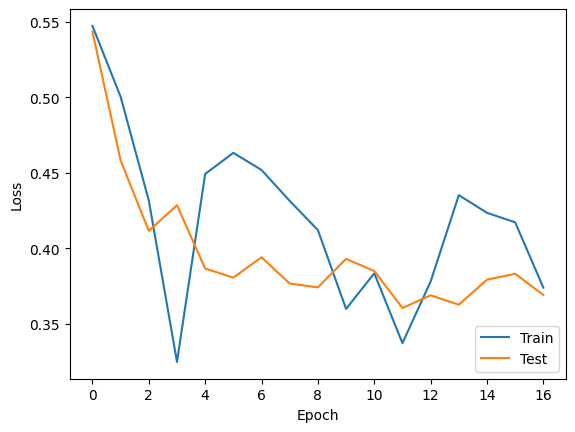

In [16]:
#make some quick plots
figure = plt.figure()
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.plot(loss_train)
plt.plot(loss_test)
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig(f"loss.pdf")